2023 Bart Smeets

# Process raw data

This code processes raw z-scan data such that it can be used for further analysis.

Its functionalities are:

- Average multiple measurements
- Calculate errorbars
- Normalise data
- Export separate Open Aperture and Closed Aperture processed data files

## Imports

- Import the necessary modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import os
from datetime import datetime

## Load data

- Create window for file selection
- Store data in data structure:

    0. Index 0 controls the individual measurements
    1. Index 1 controls the number of data points within an individual measurement
    2. Index 2 stores the different types of data of an individual measurement at a specific data point:
        * index 2 = 0: z-data
        * index 2 = 1: open aperture
        * index 2 = 2: closed aperture
        
- Average data of individual measurements


In [2]:
# Set initial directory
INITIAL_PATH = os.environ.get('THESIS_DATA')

# Create window for file selection
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
FILE_NAMES = filedialog.askopenfilenames(initialdir=INITIAL_PATH, title='Select Data Files')
root.destroy()

# Change working directory
## Directory is the folder where the selected files are located
index = FILE_NAMES[0].rfind('/')
DIRECTORY = FILE_NAMES[0][:index]
os.chdir(DIRECTORY)

# Data loading
N_MEASUREMENTS = len(FILE_NAMES)
for i in range(N_MEASUREMENTS):
    data = np.loadtxt(FILE_NAMES[i])
    ## At the first iteration, initialise data structure
    if i == 0:    
        N_DATAPOINTS = len(data[:,0])
        DATA = np.ndarray((N_MEASUREMENTS, N_DATAPOINTS, 3))    # 0: measurement; 1: data point; 2: data type
    ## Store data in data structure
    DATA[i, :, 0] = data[:,0]
    DATA[i, :, 1] = data[:, 1]
    DATA[i, :, 2] = data[:, 2]

# Average data
DATA_AVERAGE = np.ndarray((N_DATAPOINTS, 3))    # Initialise data structure
for i in range(N_DATAPOINTS):
    ## Calculate average
    OA_averge = np.average(DATA[:, i, 1])
    CA_averge = np.average(DATA[:, i, 2])
    ## Store average in data structure
    DATA_AVERAGE[:, 0] = DATA[0, :, 0]
    DATA_AVERAGE[i, 1] = OA_averge
    DATA_AVERAGE[i, 2] = CA_averge

# Create export directory
timeCode = datetime.now()
EXPORT_FOLDER = "/Normalised_Data_" + timeCode.strftime("%Y%m%d-%H%M")
EXPORT_DIRECTORY = DIRECTORY + EXPORT_FOLDER
os.mkdir(EXPORT_DIRECTORY)
os.chdir(EXPORT_DIRECTORY)


## Plot unprocessed data

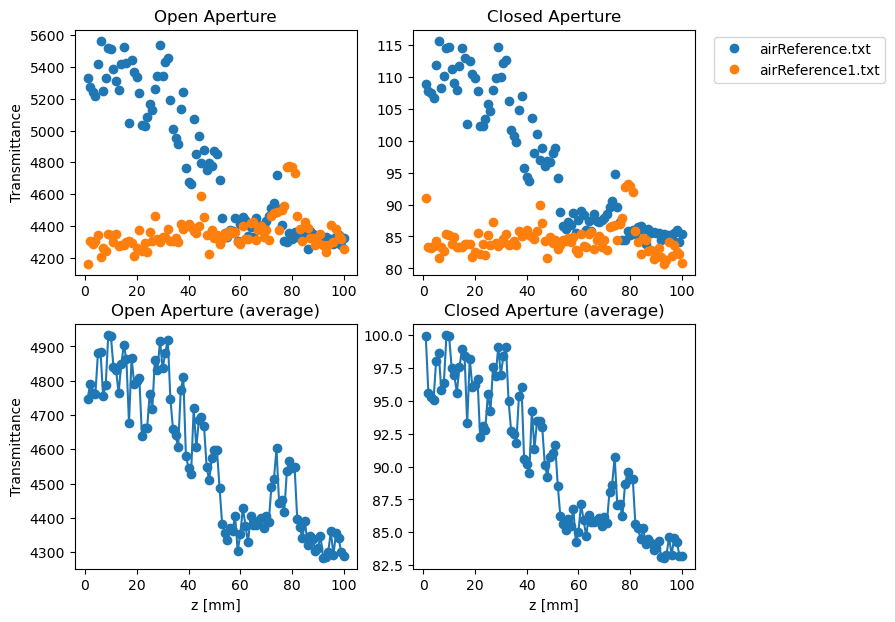

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8,7))

# Plot individual measurements
for i in range(N_MEASUREMENTS):
    file_name = FILE_NAMES[i]
    ax[0,0].plot(DATA[i, :, 0], DATA[i, :, 1], 'o', label=file_name[index+1:])
    ax[0,1].plot(DATA[i, :, 0], DATA[i, : , 2], 'o')
# Plot average of measurements
ax[1,0].plot(DATA_AVERAGE[:,0], DATA_AVERAGE[:, 1], 'o-')
ax[1,1].plot(DATA_AVERAGE[:,0], DATA_AVERAGE[:, 2], 'o-')
# Label axes
ax[0,0].legend(bbox_to_anchor=(2.9,1))
ax[0,0].set_title('Open Aperture')
ax[1,0].set_title('Open Aperture (average)')
ax[1,0].set_xlabel('z [mm]')
ax[0,0].set_ylabel('Transmittance')
ax[1,0].set_ylabel('Transmittance')
ax[0,1].set_title('Closed Aperture')
ax[1,1].set_title('Closed Aperture (average)')
ax[1,1].set_xlabel('z [mm]')

fig.savefig('RAW_DATA.png', bbox_inches='tight')
plt.show()

## Calculate errorbars

Mean Absolute Error (MAE) has been chosen to estimate the deviation of the data, because it is less sensitive to outliers than the variance.


In [22]:
MAE = np.ndarray((N_DATAPOINTS, 2))    # Initialise data structure

# Calculate the MAE for every data point
for i in range(N_DATAPOINTS):    
    MAE[i, 0] = np.sum(np.abs(DATA[:, i, 1] - DATA_AVERAGE[i,1])) / N_MEASUREMENTS
    MAE[i, 1] = np.sum(np.abs(DATA[:, i, 2] - DATA_AVERAGE[i,2])) / N_MEASUREMENTS

## Normalise data

- Normalise the data with respect to the farfield

To determine the baseline, it uses the Huber regression model, which is a linear regression model that is robust to outliers, see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

In [25]:
# Initialise data structures
DATA_AVERAGE_NORM = np.ndarray((N_DATAPOINTS, 3))
DATA_NORM = np.ndarray((N_MEASUREMENTS, N_DATAPOINTS, 3))
MAE_NORM = np.ndarray((N_DATAPOINTS,2))

# Normalise data and store in data structure
## Store z-position
DATA_AVERAGE_NORM[:, 0] = DATA_AVERAGE[:,0]
DATA_NORM[:,:,0] = DATA[:,:,0]
## Store normalised open and closed aperture and errorbars
for i in [1, 2]:
    ### Determine normalisation factor
    baseline = HuberRegressor().fit(DATA_AVERAGE[:, 0].reshape(-1,1), DATA_AVERAGE[:, i])
    normalisation = np.average(baseline.predict(DATA_AVERAGE[:, 0].reshape(-1,1)))
    ### Store normalisation
    DATA_AVERAGE_NORM[:, i] = DATA_AVERAGE[:, i] / normalisation
    MAE_NORM[:, i-1] = MAE[:, i-1] / normalisation
    for j in range(N_MEASUREMENTS):
        baseline = HuberRegressor().fit(DATA[j, :, 0].reshape(-1,1), DATA[j, :, i])
        normalisation = np.average(baseline.predict(DATA[j, :, 0].reshape(-1,1)))
        DATA_NORM[j,:, i] = DATA[j,:, i] / normalisation  

## Plot normalised data

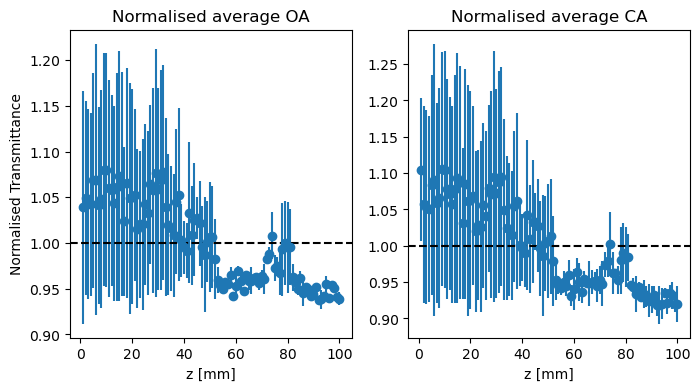

In [26]:
fig1, ax1 = plt.subplots(1, 2, figsize=(8,4))

# Plot normalised average data
ax1[0].errorbar(DATA_AVERAGE_NORM[:,0], DATA_AVERAGE_NORM[:,1], MAE_NORM[:,0], fmt='o')    # Open aperture
ax1[1].errorbar(DATA_AVERAGE_NORM[:,0], DATA_AVERAGE_NORM[:,2], MAE_NORM[:,1], fmt='o')    # Closed aperture
# Plot T=1, the normalisation reference 
ax1[0].axhline(1, color='black', linestyle='dashed')
ax1[1].axhline(1, color='black', linestyle='dashed')
# Labels
ax1[0].set_ylabel('Normalised Transmittance')
ax1[0].set_xlabel('z [mm]')
ax1[1].set_xlabel('z [mm]')
ax1[0].set_title('Normalised average OA')
ax1[1].set_title('Normalised average CA')

fig1.savefig('NORMALISED_DATA.png', bbox_inches='tight')
plt.show()

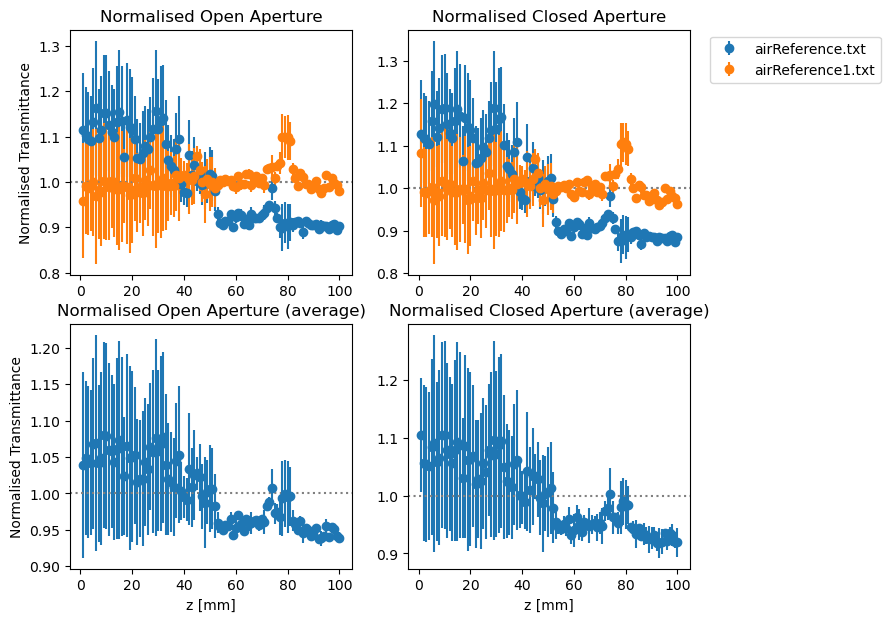

In [32]:
fig1, ax1 = plt.subplots(2, 2, figsize=(8,7))

# Plot individual measurements
for i in range(N_MEASUREMENTS):
    file_name = FILE_NAMES[i]
    ax1[0,0].errorbar(DATA_NORM[i, :, 0], DATA_NORM[i, :, 1], MAE_NORM[:,0], fmt='o', label=file_name[index+1:])
    ax1[0,1].errorbar(DATA_NORM[i, :, 0], DATA_NORM[i, : , 2], MAE_NORM[:,0], fmt='o')
    ax1[0,0].axhline(1, ls=':', color='grey')
    ax1[0,1].axhline(1, ls=':', color='grey')
# Plot average of measurements
ax1[1,0].errorbar(DATA_AVERAGE_NORM[:,0], DATA_AVERAGE_NORM[:,1], MAE_NORM[:,0], fmt='o')    # Open aperture
ax1[1,1].errorbar(DATA_AVERAGE_NORM[:,0], DATA_AVERAGE_NORM[:,2], MAE_NORM[:,1], fmt='o')    # Closed aperture
ax1[1,0].axhline(1, ls=':', color='grey')
ax1[1,1].axhline(1, ls=':', color='grey')
# Label axes
ax1[0,0].legend(bbox_to_anchor=(2.9,1))
ax1[0,0].set_title('Normalised Open Aperture')
ax1[1,0].set_title('Normalised Open Aperture (average)')
ax1[1,0].set_xlabel('z [mm]')
ax1[0,0].set_ylabel('Normalised Transmittance')
ax1[1,0].set_ylabel('Normalised Transmittance')
ax1[0,1].set_title('Normalised Closed Aperture')
ax1[1,1].set_title('Normalised Closed Aperture (average)')
ax1[1,1].set_xlabel('z [mm]')

fig1.savefig('NORMALISED_DATA.png', bbox_inches='tight')
plt.show()

## Export normalised data

In [34]:
# Intialise Open Aperture Data
OA_EXPORT = np.ndarray((N_DATAPOINTS, 3))    # 0: z-position; 1: average OA; 2: errorbar
OA_EXPORT[:, 0] = DATA_AVERAGE_NORM[:,0]
OA_EXPORT[:, 1] = DATA_AVERAGE_NORM[:, 1]
OA_EXPORT[:, 2] = MAE_NORM[:, 0]
OA_STRING = EXPORT_DIRECTORY + '/OA_AVERAGE.txt'

# Intialise Closed Aperture Data
CA_EXPORT = np.ndarray((N_DATAPOINTS, 3))    # 0: z-position; 1: average OA; 2: errorbar
CA_EXPORT[:, 0] = DATA_AVERAGE_NORM[:,0]
CA_EXPORT[:, 1] = DATA_AVERAGE_NORM[:, 2]
CA_EXPORT[:, 2] = MAE_NORM[:, 1]
CA_STRING = EXPORT_DIRECTORY + '/CA_AVERAGE.txt'

# Export Files
np.savetxt(OA_STRING, OA_EXPORT)
np.savetxt(CA_STRING, CA_EXPORT)

# Export normalised data of individual measurements
for i in range(N_MEASUREMENTS):
    ## Initialise data structure
    file_oa_export = np.ndarray((N_DATAPOINTS, 3))
    file_ca_export = np.ndarray((N_DATAPOINTS, 3))
    ## Prepare file name
    file_name = FILE_NAMES[i]
    file_oa_string = EXPORT_DIRECTORY + '/OA_' + file_name[index+1:]
    file_ca_string = EXPORT_DIRECTORY + '/CA_' + file_name[index+1:]
    ## Store data in data structure
    ### 0: z-position; 1: average OA; 2: errorbar
    file_oa_export[:, 0] = DATA_NORM[i, :, 0]
    file_oa_export[:, 1] = DATA_NORM[i, :, 1]
    file_oa_export[:, 2] = MAE_NORM[:, 0]
    file_ca_export[:, 0] = DATA_NORM[i, :, 0]
    file_ca_export[:, 1] = DATA_NORM[i, :, 2]
    file_ca_export[:, 2] = MAE_NORM[:, 1]
    ## Export data
    np.savetxt(file_oa_string, file_oa_export)
    np.savetxt(file_ca_string, file_ca_export)

# Generate input file containing all parameters necessary for zscan-fit
INPUT_FILE = pd.DataFrame(columns=['Wavelength [nm]', 'Pulse Energy [uJ]', 'zR [um]', 'W0 [um]', 'alpha [cm-1]', 'L [cm]'])
INPUT_FILE.to_csv(EXPORT_DIRECTORY + '/INPUT_FILE.csv', sep=';', index=False)

# Open output folder
os.startfile(EXPORT_DIRECTORY)